## Prevendo a Popularidade das Músicas

### Importando os pacotes

In [17]:
import os
import sys
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('CODE_PATH'))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import config, custom_funcs

sns.set_style('whitegrid')
sns.set_theme('notebook')
pd.set_option('display.precision',2)

### Importando os Dados

In [2]:
df = pd.read_csv(config.best_songs,sep=';')
df.head()

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96


In [3]:
# Observando se no início e fim de cada nome de colunas existem espaços
df.columns

Index(['title', 'artist', 'top genre', 'year', 'bpm', 'energy',
       'danceability ', 'dB', 'liveness', 'valence', 'duration',
       'acousticness', 'speechiness ', 'popularity'],
      dtype='object')

Visto que as colunas *'danceability'* e *'speechiness'* tem um espaço no início e no fim, estarei utilizando a função strip para realizar a limpeza dos nomes.

In [4]:
df.columns = df.columns.str.strip()

In [26]:
df.isnull().sum()

title           0
artist          0
top genre       0
year            0
bpm             0
energy          0
danceability    0
dB              0
liveness        0
valence         0
duration        0
acousticness    0
speechiness     0
popularity      0
dtype: int64

Como a ideia é consumir os dados consultados via API do Spotify, as *features* utilizadas serão as presentes no módulo de *Get Track's Audio Features*, sendo as que constam na imagem abaixo:

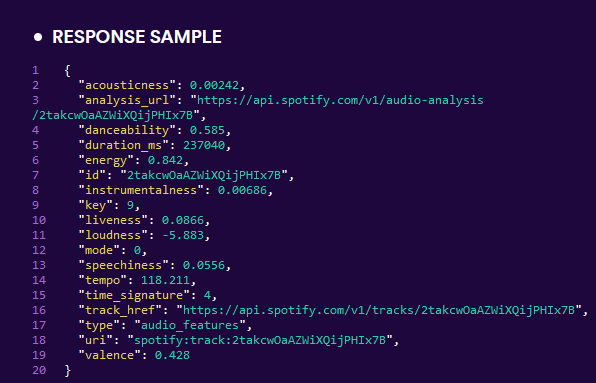

In [5]:
# Variáveis presentes na API e base utilizada para treino

list = [
    'danceability',
    'energy',
    'speechiness',
    'acousticness',
    'liveness',
    'valence',
    'popularity']

In [6]:
# Copiando o DF apenas com as features presentes na API para realizarmos o treino

num_df = df[list].copy()
num_df.head()

,danceability,energy,speechiness,acousticness,liveness,valence,popularity
0,71,68,7,6,3,65,98
1,78,59,3,44,35,73,97
2,77,64,14,74,17,53,96
3,70,81,5,25,25,86,96
4,72,62,5,42,8,17,96


In [7]:
# Definindo os dados de treino e teste

X_train, X_test, y_train, y_test = train_test_split(num_df.iloc[:,:-1],num_df.iloc[:,-1],test_size=0.3,random_state=42)

In [8]:
# Como forma de explorar os dados de treino, feito o join para também observarmos
# a label.

train_data = X_train.join(y_train)

### Exploratory Data Analysis

In [9]:
# Observando as medidas resumo do

train_data.describe()

,danceability,energy,speechiness,acousticness,liveness,valence,popularity
count,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00,1669.00
mean,67.04,69.81,10.34,15.70,17.89,53.88,70.40
std,13.81,16.34,9.80,20.47,13.50,22.43,11.48
min,18.00,11.00,2.00,0.00,2.00,4.00,5.00
25%,59.00,59.00,4.00,2.00,9.00,37.00,64.00
50%,68.00,72.00,6.00,7.00,13.00,53.00,71.00
75%,76.00,82.00,13.00,22.00,23.00,72.00,78.00
max,98.00,100.00,58.00,98.00,84.00,97.00,98.00


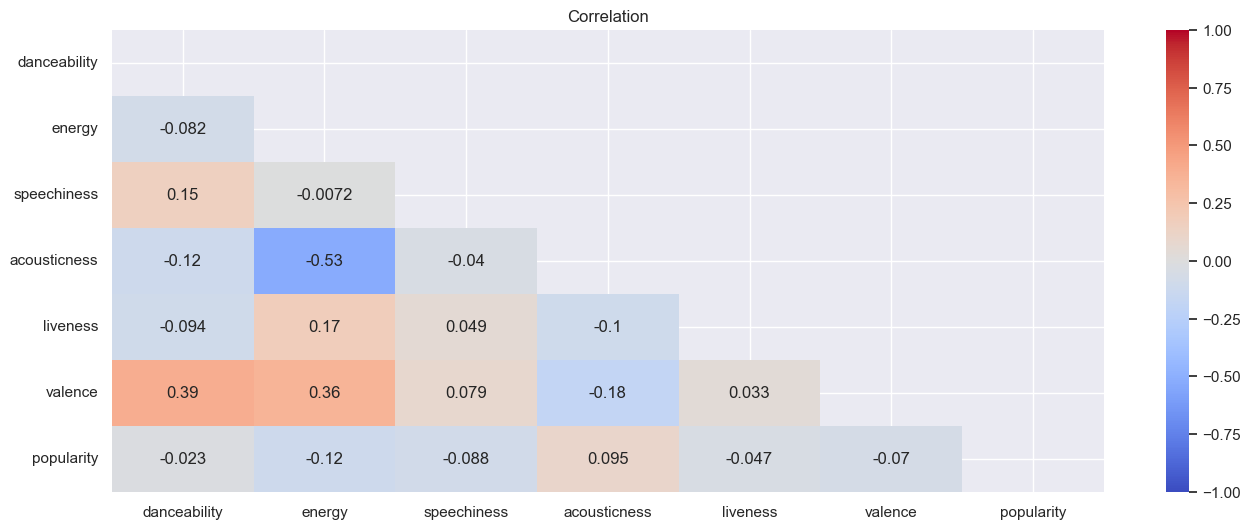

In [21]:
# Plotando a matriz de correlação com máscara.

custom_funcs.corr_matrix(train_data)

Observando a correlação de Pearson não tem-se nenhuma variável com alta correlação ao ser observado com a label (*popularity*). 

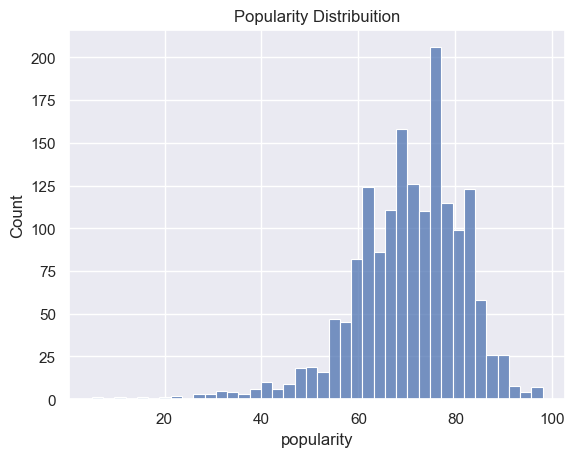

In [10]:
custom_funcs.histogram(train_data,'popularity','Popularity Distribuition')

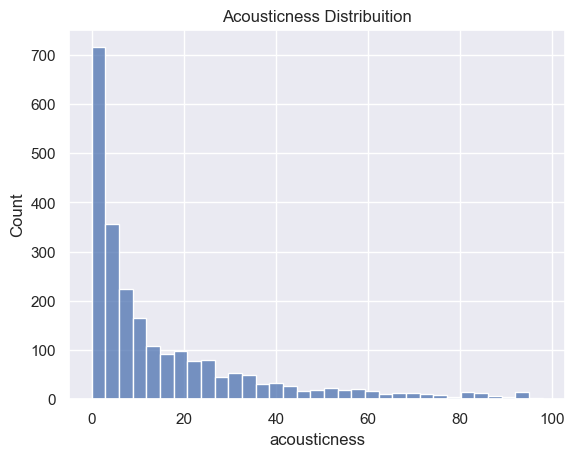

In [11]:
custom_funcs.histogram(df,'acousticness','Acousticness Distribuition')

Ao observarmos a variável *acousticness*, temos que grande parte das músicas tem os valores mais próximos de 0.

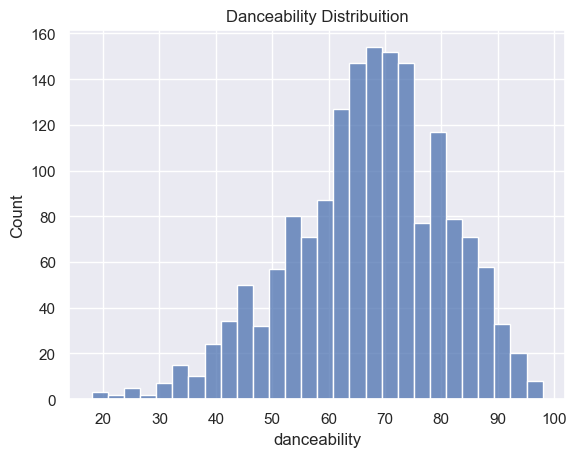

In [12]:
custom_funcs.histogram(train_data,'danceability','Danceability Distribuition')

Valence x Danceability


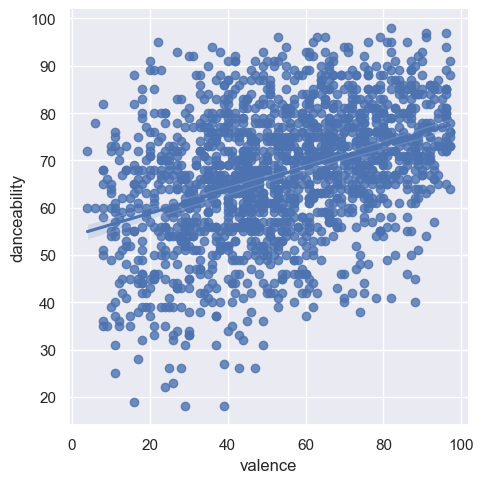

In [13]:
print('Valence x Danceability')
custom_funcs.comparative(train_data,'valence','danceability')

Valence x Energy


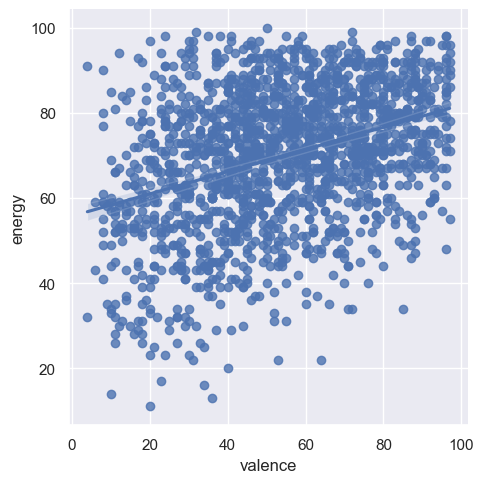

In [14]:
print('Valence x Energy')
custom_funcs.comparative(train_data,'valence','energy')

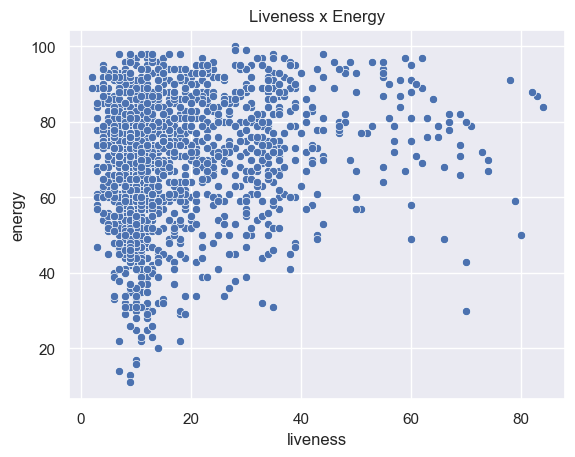

In [15]:
plt.title('Liveness x Energy')
_ = sns.scatterplot(data=train_data,x='liveness',y='energy')

Quando observarmos as features de forma bi-variada, tem-se que os dados não mostram uma tendência ao serem plotados, deixando visível os valores da correlação de Pearson acima.

### Training Model

Para prever a popularidade das músicas, testaremos 2 modelos, sendo eles o *Random Forest* e o *Gradient Boosting Regressor*.

In [18]:
rf = RandomForestRegressor(random_state=42)

In [19]:
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [20]:
pred_rf = rf.predict(X_test)

In [21]:
mean_absolute_error(y_test,pred_rf).round(2)

9.0

In [27]:
# Os hiperparametros abaixo foram tunados utilizando o optuna, na função 
# optimize, presente no código custom_funcs.py. 

gb = GradientBoostingRegressor(
    learning_rate=0.01434632525023883,
    n_estimators=400,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=3,
    random_state=42,
    )

In [28]:
gb.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01434632525023883, min_samples_leaf=3,
                          min_samples_split=10, n_estimators=400,
                          random_state=42)

In [24]:
pred_gb = gb.predict(X_test)

In [25]:
mean_absolute_error(y_test,pred_gb).round(2)

8.63

Visto que o modelo do Gradient Boosting Regressor foi o melhor, utilizaremos a extração do artefato para o AWS S3, onde o utilizaremos para a predição do app.